In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

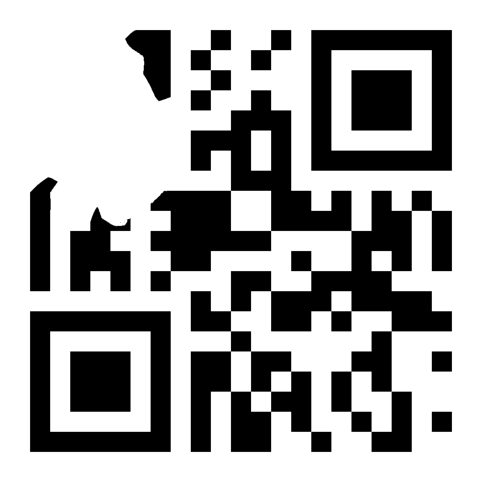

In [2]:
image_path = "07-THE-MIGHTY-FINGER.png"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert to grayscale to focus on intensity rather than color for mask creation
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Create a mask where the grayscale value is close to the color of the thumb
_, mask = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

# Morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)  # Dilate to cover all the obscured parts
mask = cv2.erode(mask, kernel, iterations=2)   # Erode to refine the edges of the mask

# Perform inpainting
inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

# Convert to binary for QR readability
gray_inpainted = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
_, final_scan_ready = cv2.threshold(gray_inpainted, 127, 255, cv2.THRESH_BINARY)

# Display the inpainted and ready-to-scan image
plt.figure(figsize=(6, 6))
plt.imshow(final_scan_ready, cmap='gray')
plt.axis('off')
plt.show()

(21, 21)


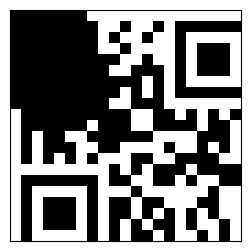

In [3]:
img = cv2.imread("07-THE-MIGHTY-FINGER.png", cv2.IMREAD_GRAYSCALE)

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    if (row != 255).any():
        start_row = row_index
        break

for row_index, row in enumerate(img[::-1]):
    if (row != 255).any():
        end_row = img.shape[0] - row_index
        break

for col_index, col in enumerate(cv2.transpose(img)):
    if (col != 255).any():
        start_col = col_index
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    if (col != 255).any():
        end_col = img.shape[1] - col_index
        break

img_no_quiet_zone = img[start_row:end_row, start_col:end_col]

img_21x21_grid = cv2.resize(img_no_quiet_zone, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_21x21_grid, cmap='gray');
print(img_21x21_grid.shape)

In [4]:
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [5]:
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
       
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [6]:
img_21x21_grid_inv = 1 - img_21x21_grid
ecl = img_21x21_grid_inv[8, 0:2]
mask = img_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [1 1]
MASK = [1 1 1]
ENC = [0, 1, 0, 1]
LEN = [0, 0, 0, 0, 0, 0, 1, 1] = 3 data symbols, each consisting of 8 bits


In [7]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [8]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)

byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1

for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

11000101 (=197) = Å
01100000 (=096) = `
01110101 (=117) = u
10000100 (=END) -- the NULL TERMINATOR, followed by padding and/or ECC
10110111 (=183) = ·
11010111 (=215) = ×
00100101 (=037) = %
10111111 (=191) = ¿
00100011 (=035) = #
11000110 (=198) = Æ
11100111 (=231) = ç
00001110 (=014) = 
11011001 (=217) = Ù
10100111 (=167) = §
01001000 (=072) = H
10100111 (=167) = §
00110001 (=049) = 1
0001 (=001) = 
10101000 (=168) = ¨
01001001 (=073) = I
10100000 (=160) =  
10111011 (=187) = »
11110111 (=247) = ÷
00000101 (=005) = 
11111111 (=255) = ÿ
